In [381]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.compose import ColumnTransformer
import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [4]:
fashion_mnist = keras.datasets.fashion_mnist

In [5]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

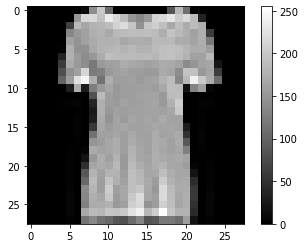

In [6]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [7]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

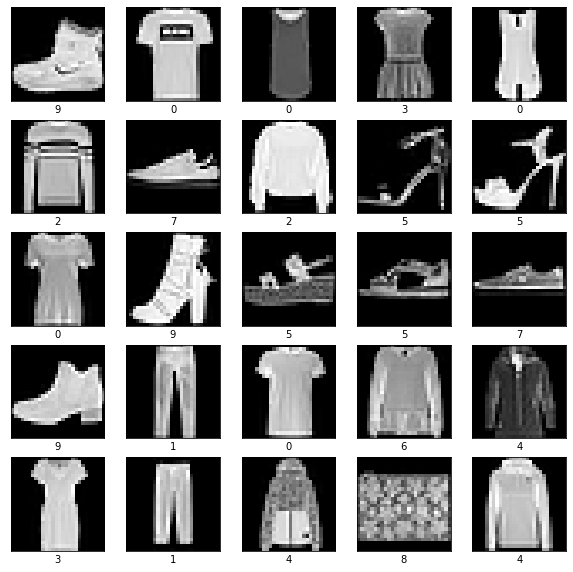

In [8]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

In [9]:

label_dictionary = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [246]:
label_dictionary

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [369]:
# First we one hot encode the labels for our training set

enc_train = OneHotEncoder(categories='auto')

enc_train.fit(train_labels.reshape(-1, 1))

onehotlabels_train = enc_train.transform(train_labels.reshape(-1,1)).toarray()

print("train shape:", onehotlabels_train.shape)

# We one hot encode the labels for our test set

enc_test = OneHotEncoder(categories='auto')

enc_test.fit(test_labels.reshape(-1, 1))

onehotlabels_test = enc_test.transform(test_labels.reshape(-1,1)).toarray()

print("test shape:", onehotlabels_test.shape)

train shape: (60000, 10)
test shape: (10000, 10)


In [363]:
def image_processing(images):

    # We transform our training images into row vectors
    tensor = images.reshape(-1, 28 * 28)
    # Add bias
    tensor = np.insert(tensor, 0, np.ones(len(tensor)), axis=1).astype(np.float32)
    print(tensor.shape)
    return tensor

In [367]:
x_train = image_processing(train_images)
x_test = image_processing(test_images)

(60000, 785)
(10000, 785)


In [378]:
def image_processing_normalized(images):

    # We transform our training images into row vectors
    tensor = images.reshape(-1, 28 * 28)
    # Normalize image
    tensor = normalize(tensor, norm = "max", axis = 1)
    # Add bias
    tensor = np.insert(tensor, 0, np.ones(len(tensor)), axis=1).astype(np.float32)
    print(tensor.shape)
    return tensor


In [379]:
x_train_normalized = image_processing_normalized(train_images)
x_test_normalized = image_processing_normalized(test_images)

(60000, 785)
(10000, 785)


In [390]:
def image_processing_scaled(images):

    # We transform our training images into row vectors
    tensor = images.reshape(-1, 28 * 28)
    # Normalize image
    tensor = scale(tensor)
    # Add bias
    tensor = np.insert(tensor, 0, np.ones(len(tensor)), axis=1).astype(np.float32)
    print(tensor.shape)
    return tensor


In [391]:
x_train_scaled = image_processing_scaled(train_images)
x_test_scaled = image_processing_scaled(test_images)

(60000, 785)
(10000, 785)


In [242]:
class LogisticRegressionSoftmax:
    def __init__(self, x, labels):
        # vector de weights para logits
        self.w = tf.get_variable("weights", dtype = tf.float32, shape = [x_train.shape[1], labels.shape[1]], initializer = tf.zeros_initializer())
        
    # Funcion para el calculo de logits
    def logits(self, x):
        #with tf.name_scope("logits"):
        return tf.matmul(x, self.w)
    
    def prediction(self, x):
        return tf.nn.softmax(self.logits(x))
    
    def accuracy(self, predictions, labels):
        accuracy = tf.equal(tf.argmax(predictions,1), tf.argmax(labels,1))
        accuracy = tf.dtypes.cast(accuracy, tf.int32)
        accuracy = tf.divide(tf.reduce_sum(accuracy), tf.shape(labels)[0])
        return accuracy
            
    def update(self, x_train, labels_train, x_test, labels_test, learningrate):
        with tf.name_scope("error"):
            train_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels_train, logits = self.logits(x_train)))
            train_error_summary = tf.summary.scalar("TrainError", train_error)
            test_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels_test, logits = self.logits(x_test)))
            test_error_summary = tf.summary.scalar("TestError", test_error)
        with tf.name_scope("accuracy"):
            train_accuracy = self.accuracy(self.prediction(x_train), labels_train)
            train_accuracy_summary = tf.summary.scalar("TrainAccuracy", train_accuracy)
            test_accuracy = self.accuracy(self.prediction(x_test), labels_test)
            test_accuracy_summary = tf.summary.scalar("TestAccuracy", test_accuracy)
        gradient = tf.gradients(train_error, [self.w])
        updated_w = tf.assign(self.w, self.w - learningrate * gradient[0])
        return updated_w, train_error, test_error, train_accuracy, test_accuracy, train_error_summary, test_error_summary, train_accuracy_summary, test_accuracy_summary
    

In [396]:
def training(lr, epochs, frecprint, x_train, x_test, labels_train, labels_test):
    # String para definicion de experimento
    string = './graphs/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +"_lr="+str(lr)+ "_epochs="+str(epochs)

    g = tf.Graph()
    with g.as_default():
        # Inicialización de objeto de clase LinearModel
        modelo = LogisticRegressionSoftmax(x_train, onehotlabels_train)
        # Definicion de placeholders para input de data a grafo
        with tf.name_scope("train_tensors"):
            tensor_x_train = tf.placeholder(tf.float32, [None,None], "tensor_x_train")
            tensor_labels_train = tf.placeholder(tf.float32, [None,None], "tensor_labels_train")
        with tf.name_scope("test_tensors"):
            tensor_x_test = tf.placeholder(tf.float32, [None,None], "tensor_x_test")
            tensor_labels_test = tf.placeholder(tf.float32, [None,None], "tensor_labels_test")
        # Utilizacion de método update para hacer el entrenamiento
        update_parameters = modelo.update(tensor_x_train, tensor_labels_train, tensor_x_test, tensor_labels_test, lr)
    
        # Writer para utilizacion de tensorboard
        writer = tf.summary.FileWriter(string, g)
        
        batch_size = 32
        
        total_steps = int((labels_train.shape[0] / batch_size) * epochs)  
        
        with tf.train.MonitoredSession() as session:
            
            for i in range(total_steps + 1):
                offset = (i * batch_size) % (labels_train.shape[0] - batch_size)
                batch_data = x_train[offset:(offset + batch_size),]
                batch_labels = labels_train[offset:(offset + batch_size),]
                feed_dict = {tensor_x_train:batch_data, tensor_labels_train:batch_labels,tensor_x_test:x_test, tensor_labels_test:labels_test}
                # Entrenamiento
                training = session.run(update_parameters, feed_dict = feed_dict)
                if (i)%frecprint == 0:
                    # Cálculo de pesos para print por cada frecprint epocas
                    weights = session.run(modelo.w, feed_dict = feed_dict)
                    # Agregar datos a writer para poder visualizarlos en tensorboard
                    writer.add_summary(training[5], i)
                    writer.add_summary(training[6], i)
                    writer.add_summary(training[7], i)
                    writer.add_summary(training[8], i)
                    print("Mini-batch:", i, "train error:", training[1], "train accuracy:", training[3])
                    print("Epoch:", int(i//(labels_train.shape[0] / batch_size)+1), "test error:", training[2], "test accuracy:", training[4])
                    print("-------------------------------------------------------------------------")
            
            return weights

            writer.close()

In [252]:
weights = training(0.1, 5, 100, x_train, x_test, onehotlabels_train, onehotlabels_test)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Batch: 0 train error: 2.3025854 train accuracy: 0.1875
Epoch: 1 test error: 46950.7 test accuracy: 0.1277
-------------------------------------------------------------------------
Batch: 100 train error: 25536.52 train accuracy: 0.6875
Epoch: 1 test error: 22837.47 test accuracy: 0.7169
-------------------------------------------------------------------------
Batch: 200 train error: 10021.326 train accuracy: 0.8125
Epoch: 1 test error: 10063.538 test accuracy: 0.7768
-------------------------------------------------------------------------
Batch: 300 train error: 44967.656 train accuracy: 0.5
Epoch: 1 test error: 22194.916 test accuracy: 0.6873
-------------------------------------------------------------------------
Batch: 400 train error: 13778.153 train accuracy: 0.84375
Epoch: 1 test error: 16110.061 test accuracy: 0.7241
------------------------------------------

Batch: 4400 train error: 21533.121 train accuracy: 0.6875
Epoch: 3 test error: 10562.2705 test accuracy: 0.8078
-------------------------------------------------------------------------
Batch: 4500 train error: 16272.969 train accuracy: 0.78125
Epoch: 3 test error: 11490.812 test accuracy: 0.7964
-------------------------------------------------------------------------
Batch: 4600 train error: 19165.146 train accuracy: 0.71875
Epoch: 3 test error: 15446.777 test accuracy: 0.7609
-------------------------------------------------------------------------
Batch: 4700 train error: 4530.3267 train accuracy: 0.8125
Epoch: 3 test error: 12908.78 test accuracy: 0.807
-------------------------------------------------------------------------
Batch: 4800 train error: 14029.3955 train accuracy: 0.78125
Epoch: 3 test error: 31333.785 test accuracy: 0.6776
-------------------------------------------------------------------------
Batch: 4900 train error: 17408.092 train accuracy: 0.71875
Epoch: 3 test

Batch: 8900 train error: 35380.867 train accuracy: 0.59375
Epoch: 5 test error: 13704.403 test accuracy: 0.7832
-------------------------------------------------------------------------
Batch: 9000 train error: 7187.76 train accuracy: 0.8125
Epoch: 5 test error: 10140.147 test accuracy: 0.8206
-------------------------------------------------------------------------
Batch: 9100 train error: 5399.336 train accuracy: 0.875
Epoch: 5 test error: 10124.323 test accuracy: 0.8229
-------------------------------------------------------------------------
Batch: 9200 train error: 28047.512 train accuracy: 0.65625
Epoch: 5 test error: 12920.782 test accuracy: 0.8089
-------------------------------------------------------------------------
Batch: 9300 train error: 13992.267 train accuracy: 0.78125
Epoch: 5 test error: 11353.135 test accuracy: 0.8171
-------------------------------------------------------------------------


In [394]:
weights_normal = training(0.1, 5, 100, x_train_normalized, x_test_normalized, onehotlabels_train, onehotlabels_test)

Batch: 0 train error: 2.3025854 train accuracy: 0.1875
Epoch: 1 test error: 2.2877376 test accuracy: 0.1127
-------------------------------------------------------------------------
Batch: 100 train error: 0.9082099 train accuracy: 0.6875
Epoch: 1 test error: 0.78719616 test accuracy: 0.7194
-------------------------------------------------------------------------
Batch: 200 train error: 0.5704254 train accuracy: 0.8125
Epoch: 1 test error: 0.66972893 test accuracy: 0.7615
-------------------------------------------------------------------------
Batch: 300 train error: 0.9378215 train accuracy: 0.65625
Epoch: 1 test error: 0.67674637 test accuracy: 0.7537
-------------------------------------------------------------------------
Batch: 400 train error: 0.50744164 train accuracy: 0.90625
Epoch: 1 test error: 0.6013043 test accuracy: 0.7908
-------------------------------------------------------------------------
Batch: 500 train error: 0.8718115 train accuracy: 0.71875
Epoch: 1 test erro

Batch: 4500 train error: 0.5289998 train accuracy: 0.84375
Epoch: 3 test error: 0.47719005 test accuracy: 0.8337
-------------------------------------------------------------------------
Batch: 4600 train error: 0.333341 train accuracy: 0.90625
Epoch: 3 test error: 0.4659323 test accuracy: 0.8401
-------------------------------------------------------------------------
Batch: 4700 train error: 0.24602896 train accuracy: 0.90625
Epoch: 3 test error: 0.4734247 test accuracy: 0.8359
-------------------------------------------------------------------------
Batch: 4800 train error: 0.37774235 train accuracy: 0.875
Epoch: 3 test error: 0.5392471 test accuracy: 0.802
-------------------------------------------------------------------------
Batch: 4900 train error: 0.44715667 train accuracy: 0.875
Epoch: 3 test error: 0.5346509 test accuracy: 0.818
-------------------------------------------------------------------------
Batch: 5000 train error: 0.38649213 train accuracy: 0.84375
Epoch: 3 test

Batch: 8900 train error: 0.8754306 train accuracy: 0.6875
Epoch: 5 test error: 0.5061451 test accuracy: 0.8256
-------------------------------------------------------------------------
Batch: 9000 train error: 0.54628253 train accuracy: 0.78125
Epoch: 5 test error: 0.5086485 test accuracy: 0.8262
-------------------------------------------------------------------------
Batch: 9100 train error: 0.36669585 train accuracy: 0.875
Epoch: 5 test error: 0.46604326 test accuracy: 0.8361
-------------------------------------------------------------------------
Batch: 9200 train error: 0.851753 train accuracy: 0.6875
Epoch: 5 test error: 0.46498564 test accuracy: 0.8407
-------------------------------------------------------------------------
Batch: 9300 train error: 0.5875407 train accuracy: 0.8125
Epoch: 5 test error: 0.46326435 test accuracy: 0.8417
-------------------------------------------------------------------------


In [395]:
weights_scaled = training(0.1, 5, 100, x_train_scaled, x_test_scaled, onehotlabels_train, onehotlabels_test)

Batch: 0 train error: 2.3025854 train accuracy: 0.1875
Epoch: 1 test error: 1.6414012 test accuracy: 0.3937
-------------------------------------------------------------------------
Batch: 100 train error: 0.851563 train accuracy: 0.71875
Epoch: 1 test error: 0.68716764 test accuracy: 0.7826
-------------------------------------------------------------------------
Batch: 200 train error: 0.43338078 train accuracy: 0.84375
Epoch: 1 test error: 0.696879 test accuracy: 0.7996
-------------------------------------------------------------------------
Batch: 300 train error: 0.81474894 train accuracy: 0.78125
Epoch: 1 test error: 0.7485042 test accuracy: 0.7744
-------------------------------------------------------------------------
Batch: 400 train error: 0.5167681 train accuracy: 0.8125
Epoch: 1 test error: 0.7729296 test accuracy: 0.763
-------------------------------------------------------------------------
Batch: 500 train error: 1.1434814 train accuracy: 0.75
Epoch: 1 test error: 0.6

Batch: 4500 train error: 0.5263186 train accuracy: 0.78125
Epoch: 3 test error: 0.6341629 test accuracy: 0.8174
-------------------------------------------------------------------------
Batch: 4600 train error: 0.31286955 train accuracy: 0.90625
Epoch: 3 test error: 0.61899036 test accuracy: 0.8179
-------------------------------------------------------------------------
Batch: 4700 train error: 0.28119987 train accuracy: 0.90625
Epoch: 3 test error: 0.634546 test accuracy: 0.8154
-------------------------------------------------------------------------
Batch: 4800 train error: 0.67329085 train accuracy: 0.8125
Epoch: 3 test error: 0.6697304 test accuracy: 0.8107
-------------------------------------------------------------------------
Batch: 4900 train error: 0.65797913 train accuracy: 0.875
Epoch: 3 test error: 0.70615125 test accuracy: 0.7981
-------------------------------------------------------------------------
Batch: 5000 train error: 0.5415325 train accuracy: 0.84375
Epoch: 3 

Batch: 9000 train error: 0.4217943 train accuracy: 0.8125
Epoch: 5 test error: 0.6807092 test accuracy: 0.8122
-------------------------------------------------------------------------
Batch: 9100 train error: 0.4541527 train accuracy: 0.84375
Epoch: 5 test error: 0.6540781 test accuracy: 0.8196
-------------------------------------------------------------------------
Batch: 9200 train error: 1.0350866 train accuracy: 0.71875
Epoch: 5 test error: 0.6692968 test accuracy: 0.8145
-------------------------------------------------------------------------
Batch: 9300 train error: 0.49905303 train accuracy: 0.8125
Epoch: 5 test error: 0.68409806 test accuracy: 0.8187
-------------------------------------------------------------------------


In [361]:
def prediction(tensor_x, img_num, weights):
    tf.logging.set_verbosity(tf.logging.ERROR)
    tf.reset_default_graph()
    tensor_x = tensor_x[img_num]
    tensor_x = tensor_x.reshape(1, 785)
    prediction = tf.get_variable("prediction", dtype = tf.int32, shape = [],initializer = tf.zeros_initializer())
    tensor_x_test = tf.placeholder(tf.float32, [tensor_x.shape[0], tensor_x.shape[1]], "tensor_x_test")
    tensor_w_test = tf.placeholder(tf.float32, [weights.shape[0], weights.shape[1]], "tensor_w_test")
    prediction_softmax = tf.argmax(tf.nn.softmax(tf.matmul(tensor_x_test, tensor_w_test)),1)
    
    with tf.train.MonitoredSession() as session:
                                 
        feed_dict = {tensor_x_test:tensor_x, tensor_w_test: weights}
        predicted_label = session.run(prediction_softmax, feed_dict = feed_dict)
        label_dictionary.get(int(predicted_label))
        plt.imshow(train_images[img_num], cmap = 'gray')
        plt.title(label_dictionary.get(int(predicted_label)))
        plt.xticks([])
        plt.yticks([])
        plt.show()
    

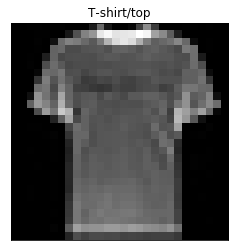

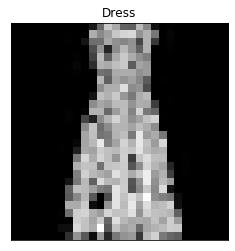

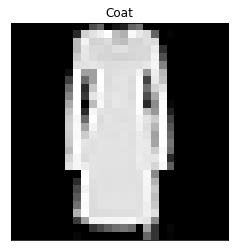

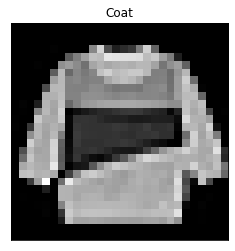

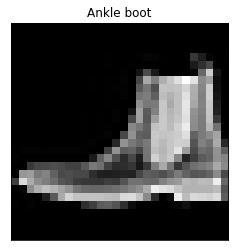

In [398]:
from random import sample 

indices = list(np.linspace(0,len(x_train), len(x_train), dtype=np.int32))

for i in sample(indices,5):
    prediction(x_train, i, weights_normal)

In [41]:
%tensorboard --logdir ./graphs --port 6007

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 18960.

In [245]:
%tensorboard --logdir ./graphs --port 6007

Reusing TensorBoard on port 6007 (pid 12960), started 11:01:49 ago. (Use '!kill 12960' to kill it.)